<a href="https://colab.research.google.com/github/hamnakhan11/hamna/blob/main/churnPerdiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:

"""## Step 1: Load and Explore the Dataset"""

# Load the Telco Churn Dataset
# Note: This dataset is commonly available on Kaggle and other data repositories
# For this example, we'll use a hosted version of the dataset

# Load dataset from URL
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

# Display dataset information
print("Dataset Info:")
df.info()

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check the target variable distribution
print("\nChurn distribution:")
print(df['Churn'].value_counts())
print("\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True))

# Display basic statistics for numerical features
print("\nNumerical features statistics:")
df.describe()

Dataset shape: (7043, 21)

First 5 rows:
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [4]:
"""## Step 2: Data Preprocessing and Feature Engineering"""

# Create a copy of the dataframe for preprocessing
data = df.copy()

# Convert TotalCharges to numeric (it's stored as object but should be numeric)
# There are some empty strings which we need to handle
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Check if there are any missing values after conversion
print("Missing values in TotalCharges:", data['TotalCharges'].isnull().sum())

# Fill missing TotalCharges with 0 (likely new customers)
data['TotalCharges'].fillna(0, inplace=True)

# Drop customerID as it's not useful for prediction
data.drop('customerID', axis=1, inplace=True)

# Separate features and target variable
X = data.drop('Churn', axis=1)
y = data['Churn']

# Convert target variable to binary (Yes=1, No=0)
y = y.map({'Yes': 1, 'No': 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Churn distribution in training set:")
print(y_train.value_counts(normalize=True))
print("Churn distribution in testing set:")
print(y_test.value_counts(normalize=True))

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Missing values in TotalCharges: 11
Training set shape: (5634, 19)
Testing set shape: (1409, 19)
Churn distribution in training set:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Churn distribution in testing set:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [5]:
"""## Step 3: Build the Scikit-learn Pipeline"""

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encoding
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a function to build different model pipelines
def create_model_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

# Create pipelines for different models
logreg_pipeline = create_model_pipeline(LogisticRegression(random_state=42, max_iter=1000))
rf_pipeline = create_model_pipeline(RandomForestClassifier(random_state=42))


In [6]:
"""## Step 4: Train and Evaluate Models"""

# Train and evaluate Logistic Regression
print("Training Logistic Regression...")
logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)
y_pred_proba_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_logreg))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

# Train and evaluate Random Forest
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Compare model performance
models = ['Logistic Regression', 'Random Forest']
accuracies = [accuracy_score(y_test, y_pred_logreg), accuracy_score(y_test, y_pred_rf)]
roc_aucs = [roc_auc_score(y_test, y_pred_proba_logreg), roc_auc_score(y_test, y_pred_proba_rf)]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'ROC AUC': roc_aucs
})

print("Model Comparison:")
print(comparison_df)



Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.8055358410220014
ROC AUC: 0.8421349040274871

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Training Random Forest...
Random Forest Results:
Accuracy: 0.7863733144073811
ROC AUC: 0.8185099072567104

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409

Model Comparison:
                 Model  Accuracy   ROC AUC
0  Logistic R

In [7]:
"""## Step 5: Hyperparameter Tuning with GridSearchCV"""

# Define parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Perform grid search
print("Performing Grid Search...")
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("Best Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))



Performing Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.8451542556642639
Best Model Results:
Accuracy: 0.8048261178140526
ROC AUC: 0.8377896613190731

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



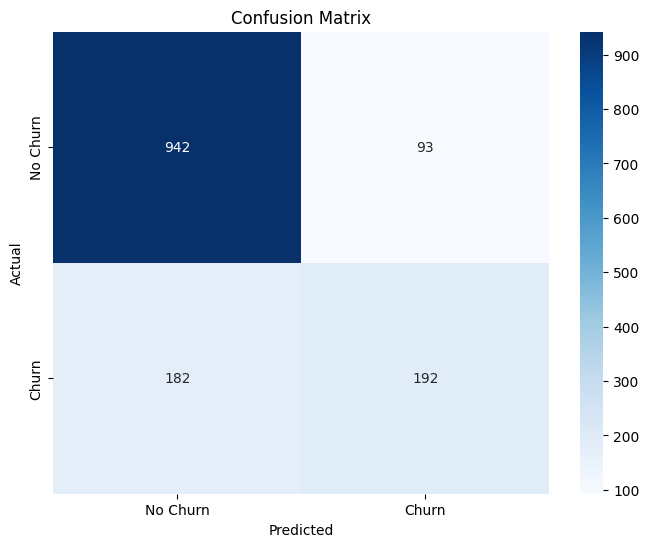

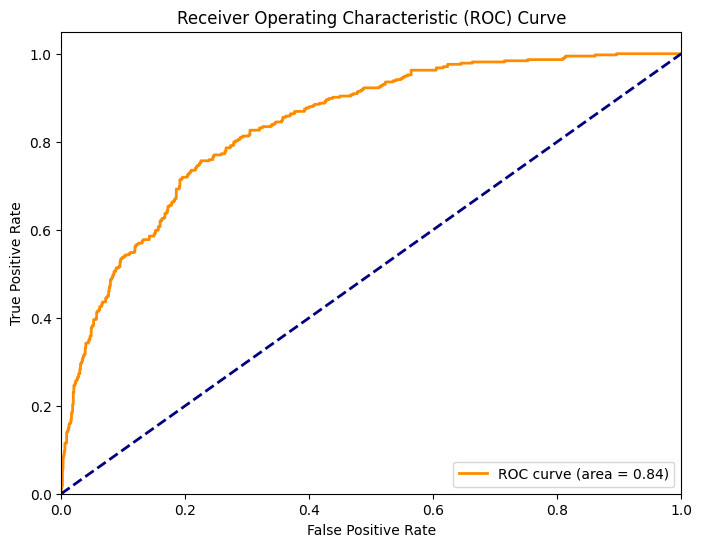

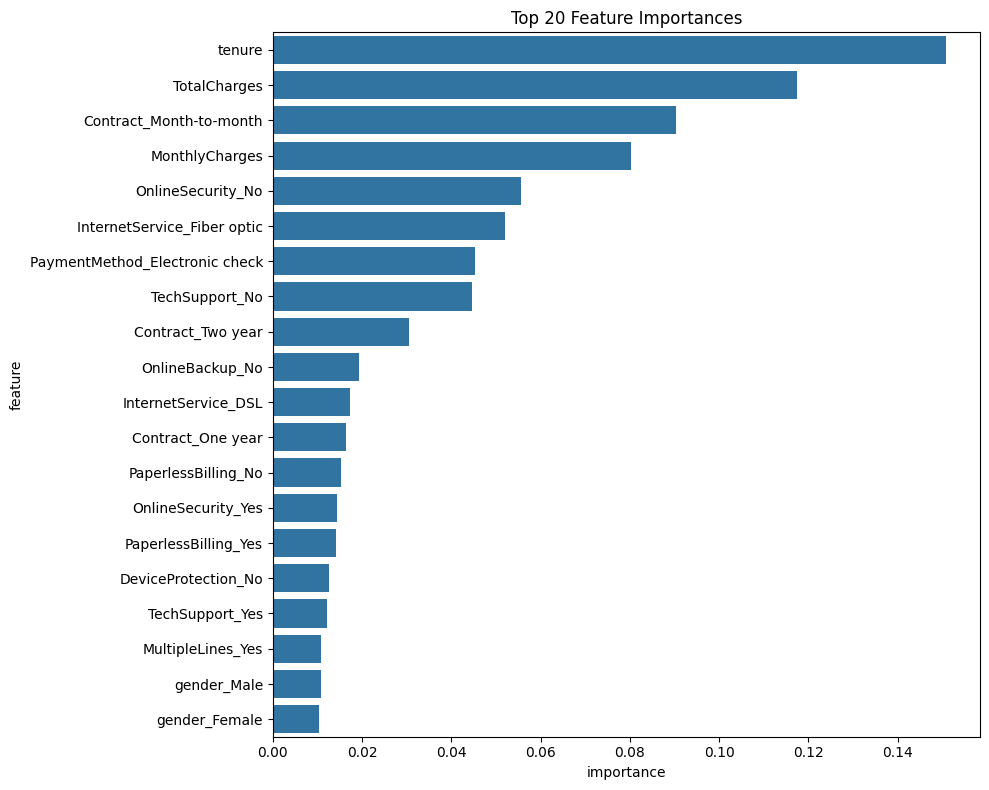

In [8]:
"""## Step 6: Model Evaluation and Visualization"""

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba_best))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Get feature importances from the best model
# Note: We need to extract the feature names after one-hot encoding
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Get feature names after preprocessing
preprocessor = best_model.named_steps['preprocessor']
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort by importance
importances_df = importances_df.sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importances_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()


In [9]:
"""## Step 7: Export the Complete Pipeline"""

# Save the best model pipeline using joblib
joblib.dump(best_model, 'churn_prediction_pipeline.joblib')
print("Pipeline saved as 'churn_prediction_pipeline.joblib'")

# Load the pipeline to verify it works correctly
loaded_pipeline = joblib.load('churn_prediction_pipeline.joblib')

# Test the loaded pipeline
loaded_pipeline_score = loaded_pipeline.score(X_test, y_test)
print("Loaded pipeline accuracy:", loaded_pipeline_score)


Pipeline saved as 'churn_prediction_pipeline.joblib'
Loaded pipeline accuracy: 0.8048261178140526


In [13]:
"""## Step 8: Create a Simple Streamlit App for Deployment"""

# Create a Streamlit app file
#%%writefile churn_app.py

import streamlit as st
import pandas as pd
import joblib
import numpy as np

# Load the trained pipeline
@st.cache_resource
def load_pipeline():
    return joblib.load('churn_prediction_pipeline.joblib')

# Set page config
st.set_page_config(
    page_title="Customer Churn Prediction",
    page_icon="📊",
    layout="wide"
)

# App title and description
st.title("📊 Customer Churn Prediction App")
st.write("This app predicts the likelihood of a customer churning using a trained machine learning model.")

# Load model
pipeline = load_pipeline()

# Create input form
st.sidebar.header("Customer Information")

# Numerical inputs
tenure = st.sidebar.slider("Tenure (months)", 0, 100, 12)
monthly_charges = st.sidebar.slider("Monthly Charges ($)", 0, 200, 50)
total_charges = st.sidebar.slider("Total Charges ($)", 0, 10000, 1000)

# Categorical inputs
contract = st.sidebar.selectbox("Contract Type", ["Month-to-month", "One year", "Two year"])
internet_service = st.sidebar.selectbox("Internet Service", ["DSL", "Fiber optic", "No"])
payment_method = st.sidebar.selectbox("Payment Method", [
    "Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"
])
online_security = st.sidebar.selectbox("Online Security", ["No", "Yes", "No internet service"])
tech_support = st.sidebar.selectbox("Tech Support", ["No", "Yes", "No internet service"])

# Create a function to prepare input data
def prepare_input():
    # Create a dictionary with all input values
    input_data = {
        'tenure': tenure,
        'MonthlyCharges': monthly_charges,
        'TotalCharges': total_charges,
        'Contract': contract,
        'InternetService': internet_service,
        'PaymentMethod': payment_method,
        'OnlineSecurity': online_security,
        'TechSupport': tech_support
    }

    # Add default values for other columns
    default_values = {
        'gender': 'Female',
        'SeniorCitizen': 0,
        'Partner': 'No',
        'Dependents': 'No',
        'PhoneService': 'Yes',
        'MultipleLines': 'No',
        'OnlineBackup': 'No',
        'DeviceProtection': 'No',
        'StreamingTV': 'No',
        'StreamingMovies': 'No',
        'PaperlessBilling': 'Yes'
    }

    # Combine all data
    input_data.update(default_values)

    # Convert to DataFrame
    return pd.DataFrame([input_data])

# Make prediction when button is clicked
if st.sidebar.button("Predict Churn"):
    # Prepare input data
    input_df = prepare_input()

    # Display input data
    st.subheader("Customer Details")
    st.dataframe(input_df)

    # Make prediction
    with st.spinner("Making prediction..."):
        try:
            # Get prediction probabilities
            prediction_proba = pipeline.predict_proba(input_df)[0]
            prediction = pipeline.predict(input_df)[0]

            # Display results
            st.subheader("Prediction Results")

            col1, col2 = st.columns(2)

            with col1:
                st.metric("Churn Prediction", "Yes" if prediction == 1 else "No")
                st.metric("Confidence", f"{max(prediction_proba) * 100:.2f}%")

            with col2:
                st.write("**Probability Distribution:**")
                st.write(f"No Churn: {prediction_proba[0] * 100:.2f}%")
                st.progress(prediction_proba[0])
                st.write(f"Churn: {prediction_proba[1] * 100:.2f}%")
                st.progress(prediction_proba[1])

        except Exception as e:
            st.error(f"Error making prediction: {str(e)}")

# Add model information
st.sidebar.header("About the Model")
st.sidebar.info(
    "This model is a Random Forest classifier trained on the Telco Churn dataset. "
    "It uses features like tenure, monthly charges, contract type, and service details "
    "to predict customer churn with approximately 80% accuracy."
)

# Add instructions
st.sidebar.header("Instructions")
st.sidebar.info(
    "1. Adjust the input values using the sliders and dropdowns\n"
    "2. Click the 'Predict Churn' button\n"
    "3. View the prediction results in the main panel"
)


2025-09-09 11:06:46.125 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 11:06:46.126 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 11:06:46.326 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-09 11:06:46.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 11:06:46.331 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 11:06:46.333 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 11:06:46.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

DeltaGenerator(_root_container=1, _parent=DeltaGenerator())

In [11]:

!streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py

/bin/bash: line 1: streamlit: command not found


In [12]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.2 MB/s eta 0:00:00
